# Exploring the Latent Space

##### Authors:
1. Ovidio Manteiga Moar
1. Carlos Villar Martínez

In [32]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import glob, os
import PIL

from tensorflow.keras import layers, models, callbacks, utils, metrics, optimizers
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from Data_pre import prepare_data_generator_GAN
from Data_pre import prepare_data_generator_VAE
from utils import display
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, callbacks, utils, metrics, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint 
from keras.utils.vis_utils import plot_model
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Explore VAE latent space


In [33]:
INPUT_DIM = (64, 64, 1)
BATCH_SIZE = 4096
Z_DIM = 100

# ENCODER
def build_vae_encoder(input_dim, output_dim, conv_filters, conv_kernel_size, conv_strides):
  
    # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu, 
    # BatchNormalization and Dropout.
    # Otherwise, the names of above mentioned layers in the model 
    # would be inconsistent
    global K
    K.clear_session()
    
    # Number of Conv layers
    n_layers = len(conv_filters)

    # Define model input
    encoder_input = Input(shape = input_dim, name = 'encoder_input')
    x = encoder_input

    # Add convolutional layers
    for i in range(n_layers):
        x = Conv2D(filters = conv_filters[i], 
            kernel_size = conv_kernel_size[i],
            strides = conv_strides[i], 
            padding = 'same',
            name = 'encoder_conv_' + str(i)
            )(x)

        x = LeakyReLU()(x)
        
    # Required for reshaping latent vector while building Decoder
    shape_before_flattening = K.int_shape(x)[1:] 
    
    x = Flatten()(x)
    mean_mu = Dense(output_dim, name = 'mu')(x)
    log_var = Dense(output_dim, name = 'log_var')(x)

    # Defining a function for sampling
    def sampling(args):
        mean_mu, log_var = args
        epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
        return mean_mu + K.exp(log_var/2)*epsilon   

    # Using a Keras Lambda Layer to include the sampling function as a layer 
    # in the model
    encoder_output = Lambda(sampling, name='encoder_output')([mean_mu, log_var])


    return encoder_input, encoder_output, mean_mu, log_var, shape_before_flattening, Model(encoder_input, encoder_output)


vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_shape_before_flattening, vae_encoder  = build_vae_encoder(
    input_dim = INPUT_DIM,
    output_dim = Z_DIM, 
    #conv_filters = [32, 64, 64, 64],
    conv_filters = [16, 32, 32, 32],
    conv_kernel_size = [3,3,3,3],
    conv_strides = [2,2,2,2])

def build_decoder(input_dim, shape_before_flattening, conv_filters, conv_kernel_size, conv_strides):

    # Number of Conv layers
    n_layers = len(conv_filters)

    # Define model input
    decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')

    # To get an exact mirror image of the encoder
    x = Dense(np.prod(shape_before_flattening))(decoder_input)
    x = Reshape(shape_before_flattening)(x)

    # Add convolutional layers
    for i in range(n_layers):
        x = Conv2DTranspose(
            filters = conv_filters[i], 
            kernel_size = conv_kernel_size[i],
            strides = conv_strides[i], 
            padding = 'same',
            name = 'decoder_conv_' + str(i)
            )(x)
        
        # Adding a sigmoid layer at the end to restrict the outputs 
        # between 0 and 1
        if i < n_layers - 1:
            x = LeakyReLU()(x)
        else:
            x = Activation('sigmoid')(x)

    # Define model output
    decoder_output = x

    return decoder_input, decoder_output, Model(decoder_input, decoder_output)

decoder_input, decoder_output, vae_decoder = build_decoder(input_dim = Z_DIM,
    shape_before_flattening = vae_shape_before_flattening,
    #conv_filters = [64,64,32,3],        
    conv_filters = [32,32,16,1],
    conv_kernel_size = [3,3,3,3],
    conv_strides = [2,2,2,2]
    )

vae_input = vae_encoder_input
vae_output = vae_decoder(vae_encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
vae = Model(vae_input, vae_output)

vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 encoder_conv_0 (Conv2D)        (None, 32, 32, 16)   160         ['encoder_input[0][0]']          
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 32, 32, 16)   0           ['encoder_conv_0[0][0]']         
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 16, 16, 32)   4640        ['leaky_re_lu[0][0]']            
                                                                                            

In [34]:
DATA_FOLDER = "./Dataset/img_align_celeba"
vae.load_weights("./vae_checkpoint/checkpoint.ckpt")

Total number of images: 202599
Found 202599 images belonging to 1 classes.


c:\Users\Ovidio\anaconda3\envs\dl2\Lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(5, 64, 64, 1)


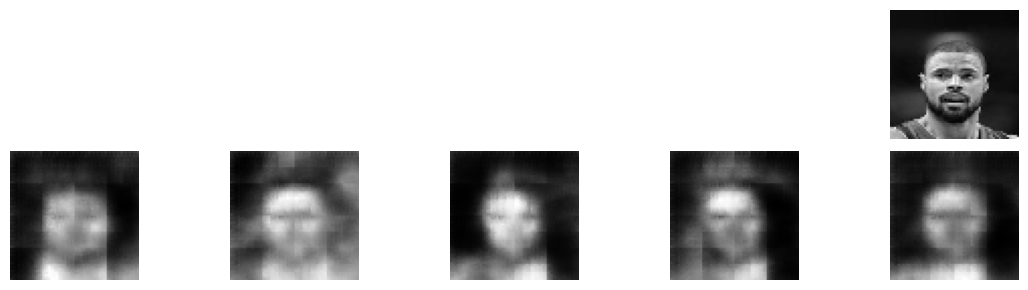

In [35]:
data_flow, NUM_IMAGES = prepare_data_generator_VAE(DATA_FOLDER, INPUT_DIM, 1)

example_batch = next(data_flow)
images = example_batch[0]
n_to_show = 5
encodings = vae_encoder.predict(images)
enc5 = np.repeat(encodings, repeats=n_to_show, axis=0)
enc5 += np.random.normal(0.0, 1.0, size = (n_to_show,Z_DIM))
reconst_images = vae_decoder.predict(enc5)
print(reconst_images.shape)
fig = plt.figure(figsize=(12, 3))
fig.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, hspace=0.1, wspace=0.1)

img = images[0]
sub = fig.add_subplot(2, n_to_show, i+1)
sub.axis('off')        
sub.imshow(img,cmap='gray')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img,cmap='gray')
plt.show()

# Explore GAN latent space

In [36]:
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 64
NUM_FEATURES = 32
Z_DIM = 32
EPOCHS = 100
STEPS_PER_EPOCH=10
LEARNING_RATE = 0.0002
CRITIC_STEPS = 3
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9
#COLOR_MODE "rgb" or "graysacale"
COLOR_MODE = "rgb"

# CRITIC
critic_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(critic_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(512, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(1, kernel_size=4, strides=1, padding="valid")(x)
critic_output = layers.Flatten()(x)
critic = models.Model(critic_input, critic_output)

# GENERATOR
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
x = layers.Conv2DTranspose(512, kernel_size=4, strides=1, padding="valid", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(CHANNELS, kernel_size=4, strides=2, padding="same", activation="tanh")(x)
generator = models.Model(generator_input, generator_output)

# WGANGP
class WGANGP(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(WGANGP, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(WGANGP, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.c_loss_metric, self.c_wass_loss_metric, self.c_gp_metric, self.g_loss_metric]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

            with tf.GradientTape() as tape:
                fake_images = self.generator(random_latent_vectors, training=True)
                fake_predictions = self.critic(fake_images, training=True)
                real_predictions = self.critic(real_images, training=True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(real_predictions)
                c_gp = self.gradient_penalty(batch_size, real_images, fake_images)
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(zip(c_gradient, self.critic.trainable_variables))

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_predictions = self.critic(fake_images, training=True)
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))

        """
        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}
        """
    
    
    
      # Calculate Critic and Generator Accuracy
        c_acc = tf.reduce_mean(tf.cast(tf.math.greater(real_predictions, 0), tf.float32)) * 100
        g_acc = tf.reduce_mean(tf.cast(tf.math.less(fake_predictions, 0), tf.float32)) * 100

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        #return {m.name: m.result() for m in self.metrics,'c_acc': c_acc,'g_acc': g_acc}    
        return {**{m.name: m.result() for m in self.metrics}, 'c_acc': c_acc, 'g_acc': g_acc}

# Create a GAN
wgangp = WGANGP(critic=critic, generator=generator, latent_dim=Z_DIM, critic_steps=CRITIC_STEPS, gp_weight=GP_WEIGHT)

Instructions for updating:
Colocations handled automatically by placer.


In [37]:
wgangp.load_weights("./checkpoint/checkpoint.ckpt")

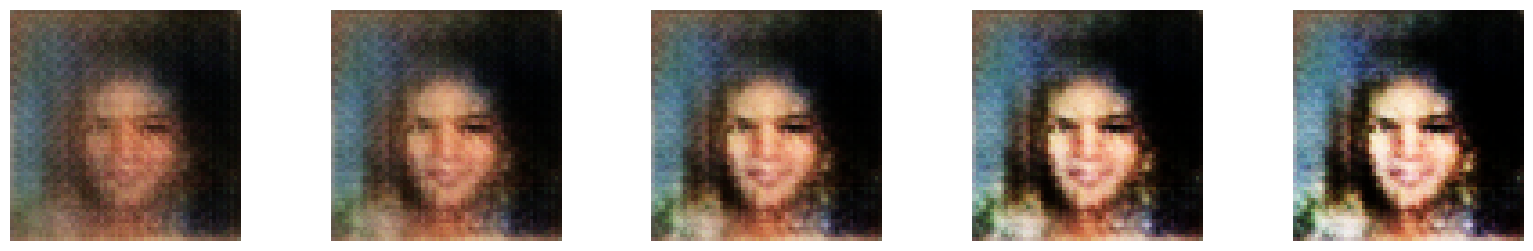

In [38]:
z_sample = np.random.normal(size=(1, Z_DIM))
rows = 5  # Number of rows in the matrix
cols = Z_DIM  # Number of columns in the matrix
matrix = np.empty((0, cols), dtype=np.float32)  # Initialize an empty matrix
row0 = np.random.rand(1, cols)
matrix = np.append(matrix, row0, axis=0) 
prev_row = row0
for i in range(rows):
    row = prev_row
    row = row+0.2
    matrix = np.append(matrix, row, axis=0)  # Append the row to the matrix
    prev_row = row

imgs = wgangp.generator.predict(matrix)
display(imgs, n=rows, cmap=None)